TODO:  
- Improve comments particularly in the latter portion to support more effective teaching... (what do we want students to draw their attention to ?)
- In the regression sections we need to draw a direct relationship between the math / math notation and the code.  Right now the notation is too abstract to be directly connected to the code.
- Make figure generation consistent

# Ridge-regression (Regression + regularization) mini-tutorial

In this set of exercises we will try to predict the neural activity from videos of animal behavior using ridge-regression.  This particular group of neurons have been classified as NOT stimulus-selective, so we are interested in understanding what they are doing. The motivation for this regression analysis is to investigate whether the neural activity is explained by mouse behavior.

TODO: Add more context for where the data came from

Set up python packages and load data

In [23]:
# This cell imports all the functions and data we need.
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function for gaussian_filtering
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
from scipy.stats import zscore
import urllib
%matplotlib inline 

# download 2-photon data
if not os.path.isfile('data/mesoscale.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscale.npy') as response:
        with open('data/mesoscale.npy','wb') as f:
            f.write(response.read())

data = np.load('data/mesoscale.npy',allow_pickle=True).item()

# Extract the data into variables
neural_data = zscore(data['spks'], axis=1) # 2-photon neural activity with mean 0 and standard deviation, collected at 3Hz
behaviorSVD = data['behSVD'] # video of the mouse's face during behavior projected onto the top 500 principal components
del data

# 1) Prepare neural data (bin + PCA)

In [24]:
# TODO REMOVE THIS AND PLACE dimensionality reduced data into a data file to load.
# Bin the behavior into 1 second bins.
tbin = int(3)
NT = behaviorSVD.shape[1]
nt = int(np.floor(NT/tbin))
behaviorSVD -= behaviorSVD.mean(axis=1)[:,np.newaxis]

# Bin the neural activity into 1 second bins.
# TODO: break this binning down into something that looks simpler... or is better explained
beh = np.reshape(behaviorSVD[:,:nt*tbin], (behaviorSVD.shape[0], nt, tbin)).mean(axis=-1)

# using this format bin the neural activity (X)
binned_neural = np.reshape(neural_data[:,:nt*tbin], (neural_data.shape[0], nt, tbin)).mean(axis=-1)

print(binned_neural.shape)

(5439, 3333)


In [25]:
# Perform principal components analysis (PCA) on the neural activity
from sklearn.decomposition import PCA

pca = PCA(n_components=256).fit(binned_neural)
V = pca.components_ # time components
sv = pca.singular_values_
U = np.matmul(binned_neural,V.T) / sv # neuron components
V *= sv[:,np.newaxis]
binned_neural_reduced = V

# 2) Prediction of Neural principal components using Behavioral principal components

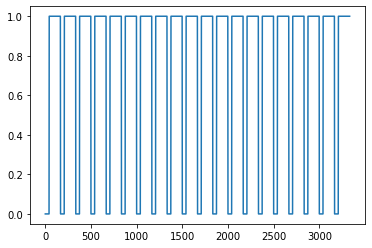

In [26]:
# First determine how to split the data into train and test sets
# *** use interleaved segments ***
nsegs = 20
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0

plt.plot(itrain)
plt.show()



Can you determine how I did the split above? Why might I have split into segments rather than randomly interleaving time-points?

TODO: CARSEN Will you give a short explanation for these questions

# Ridge Regression

If you want to regularize the linear regression:

$$ A = (X_\text{train}X_\text{train}^\top + \lambda I)^{-1} (X_\text{train} Y_\text{train}^\top)$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$

In [19]:
#### PREDICT USING BEHAVIOR PC'S 

## regularized linear regression from behavior to neural PC's
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e6 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], binned_neural_reduced[:,itrain].T))

Vpred_ridge = np.matmul(A.T, beh[:,itest])

varexp_ridge = 1 - ((Vpred_ridge - binned_neural_reduced[:,itest])**2).sum(axis=1)/(binned_neural_reduced[:,itest]**2).sum(axis=1)

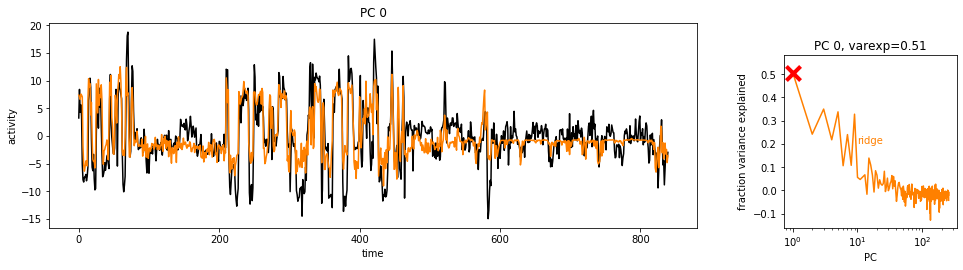

In [20]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(binned_neural_reduced[ipc,itest],color=[0,0,0])
ax.plot(Vpred_ridge[ipc], color=[1,.5,0])
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_ridge[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_ridge.size+1), varexp_ridge, color=[1,.5,0])
ax.text(10,0.2,'ridge', color=[1,.5,0])
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_ridge[ipc]))
plt.show()

# Compare to linear regression

Now use linear regression to perform the prediction, predict $Y$ using $X$:

$$ A = (X_\text{train}X_\text{train}^\top)^{-1} (X_\text{train} Y_\text{train}^\top)$$

In [21]:
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], binned_neural_reduced[:,itrain].T))

Vpred_linear = np.matmul(A.T, beh[:,itest])

varexp_linear = 1 - ((Vpred_linear - binned_neural_reduced[:,itest])**2).sum(axis=1)/(binned_neural_reduced[:,itest]**2).sum(axis=1)

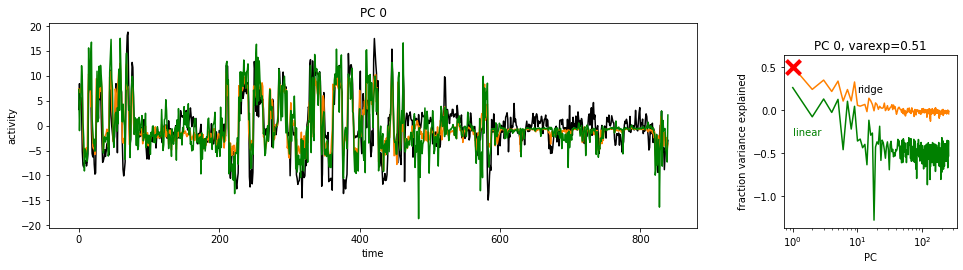

In [22]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(binned_neural_reduced[ipc,itest],color=[0,0,0])
ax.plot(Vpred_ridge[ipc], color=[1,.5,0])
ax.plot(Vpred_linear[ipc],  color=[0.,.5,0])
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.scatter(ipc+1, varexp_ridge[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_ridge.size+1), varexp_ridge, color=[1,.5,0])
ax.semilogx(np.arange(1,varexp_linear.size+1), varexp_linear, color=[0.,.5,0])
ax.text(1,-.3,'linear',color=[0,.5,0])
ax.text(10,0.2,'ridge')
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_ridge[ipc]))
plt.show()